# Exploring the data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

train = pd.read_csv('train.csv')

## Overview

In [2]:
print 'Number of training observations:', len(train.index)
train.head()

Number of training observations: 26729


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Missing values by column

In [3]:
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

## Examining the dependent variable, `OutcomeType`

What happened to the animals?

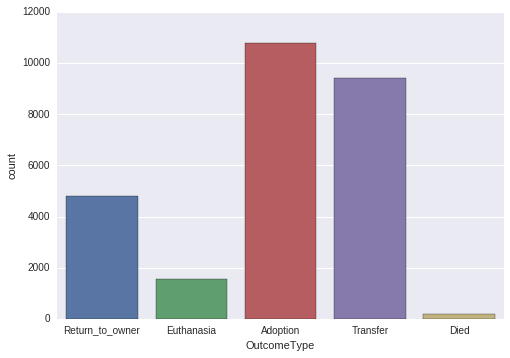

In [4]:
sns.countplot(x = "OutcomeType", data = train)

What are the possible `OutcomeSubtype`s for each `OutcomeType`?

In [5]:
train.groupby(['OutcomeType', 'OutcomeSubtype']).agg(['count'])

AnimalID  Name DateTime AnimalType  \
                                   count count    count      count   
OutcomeType OutcomeSubtype                                           
Adoption    Barn                       1     0        1          1   
            Foster                  1800  1542     1800       1800   
            Offsite                  165   132      165        165   
Died        At Vet                     4     3        4          4   
            Enroute                    8     1        8          8   
            In Foster                 52    29       52         52   
            In Kennel                114    35      114        114   
            In Surgery                 3     2        3          3   
Euthanasia  Aggressive               320   278      320        320   
            Behavior                  86    74       86         86   
            Court/Investigation        6     6        6          6   
            Medical                   66    38       66         66   
            Rabies Risk               74    43       74         74   
            Suffering               1002   301     1002       1002   
Transfer    Barn                       1     1        1          1   
            Partner                 7816  4436     7816       7816   
            SCRP                    1599    58     1599       1599   

                                SexuponOutcome AgeuponOutcome Breed Color  
                                         count          count count count  
OutcomeType OutcomeSubtype                                                 
Adoption    Barn                             1              1     1     1  
            Foster                        1800           1800  1800  1800  
            Offsite                        165            165   165   165  
Died        At Vet                           4              4     4     4  
            Enroute                          8              8     8     8  
            In Foster                       52             52    52    52  
            In Kennel                      114            114   114   114  
            In Surgery                       3              3     3     3  
Euthanasia  Aggressive                     320            320   320   320  
            Behavior                        86             86    86    86  
            Court/Investigation              6              6     6     6  
            Medical                         66             66    66    66  
            Rabies Risk                     74             74    74    74  
            Suffering                     1002           1000  1002  1002  
Transfer    Barn                             1              1     1     1  
            Partner                       7816           7816  7816  7816  
            SCRP                          1599           1583  1599  1599

I sort of assume that we can't use `OutcomeSubtype` to predict `OutcomeType`...right? I will have to check...

## Examining the independent variables

### `AnimalType`

Whether it's a cat or a dog.

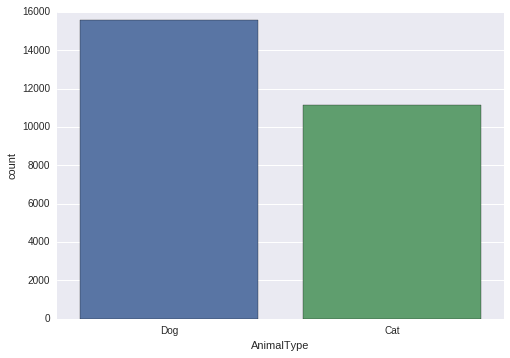

In [6]:
sns.countplot(x = "AnimalType", data = train)

`OutcomeType` by `AnimalType`

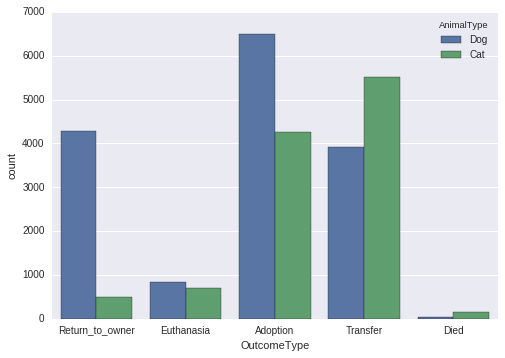

In [7]:
sns.countplot(x = "OutcomeType", hue = "AnimalType", data = train)

Visually, there looks to be a strong relationship between the outcome and what kind of animal there is - dogs are much more frequently returned to their owners, cats are more likely to die, etc.

### `SexuponOutcome`

This variable measures the sex of the animal as well as whether or not it is able to reproduce at the time of the outcome.

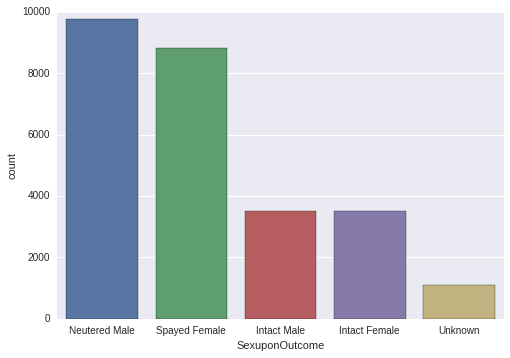

In [8]:
sns.countplot(x = "SexuponOutcome", data = train)

I'm thinking that these should be split into the following 2 variables instead of being in a single variable:

* Sex - Male / Female
* NeuteredSprayed - True / False

There is probably an interaction between these two variables, so some models (such as logistic regression) would need that interaction term left in, whereas other models (random forests) could discover these interactions.

In [9]:
def create_sex_variables(SexuponOutcome):
    results = []
    for row in SexuponOutcome:
        row = row.split(' ')
        if len(row) == 1:
            row = ['Unknown', 'Unknown']
        results.append(row)
    return zip(*[['Neutered', x[1]] if x[0] == 'Spayed' else x for x in results])

# 1 NA value, fill it in with 'Unknown'
NeuteredSprayed, Sex =create_sex_variables(list(train['SexuponOutcome'].fillna('Unknown')))
train['NeuteredSprayed'] = NeuteredSprayed
train['Sex'] = Sex
train.drop(['SexuponOutcome'], axis = 1, inplace = True)

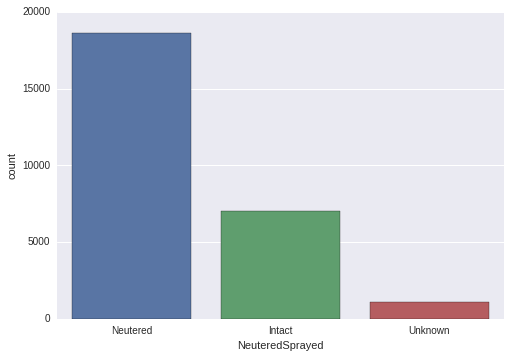

In [10]:
sns.countplot(x = "NeuteredSprayed", data = train)

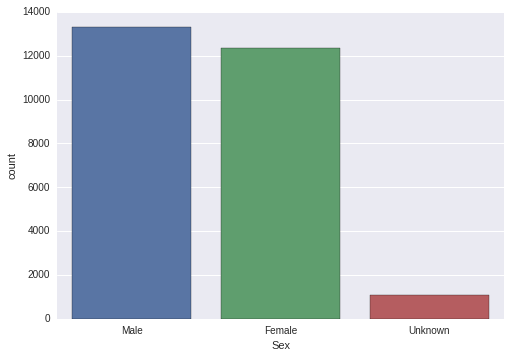

In [11]:
sns.countplot(x = "Sex", data = train)

### `AgeuponOutcome` 

Should be transformed into a numerical variable. There are 18 NAs - given how few, let's not worry too much about them and just impute the mean.

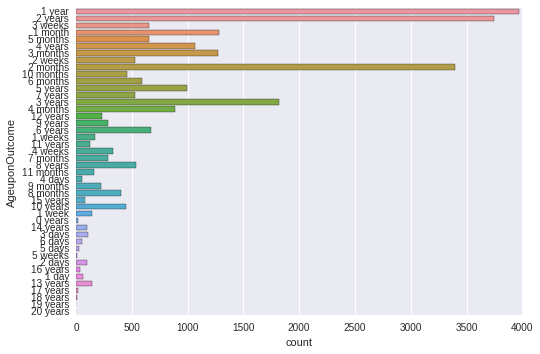

In [12]:
sns.countplot(y = "AgeuponOutcome", data = train)

In [13]:
def create_age_in_years(ages):
    results = []
    units = {'days': 365.0, 'weeks': 52.0, 'months': 12.0}
    for age in ages:
        if age == 'NA':
            results.append('NA')
        else:
            duration, unit = age.split(' ')
            results.append(float(duration) / units.get(unit, 1.0))
    impute = np.mean([age for age in results if age != 'NA'])
    return [age if age != 'NA' else impute for age in results]

ages = create_age_in_years(list(train['AgeuponOutcome'].fillna('NA')))
train['Age'] = ages
train.drop(['AgeuponOutcome'], axis = 1, inplace = True)

Look at the distribution of ages:

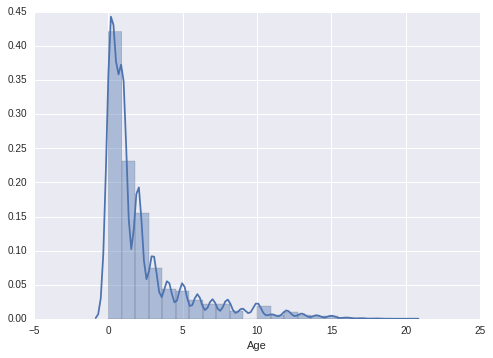

In [19]:
sns.distplot(train['Age'], bins = 22)

The right skew makes sense in the context of age.

### `Breed`

Nubmer of distinct breeds:

In [20]:
len(train['Breed'].unique())

1380

Breed only makes sense in the context of the animal species, of `AnimalType`

In [21]:
print 'Number of cat breeds:', len(train[train['AnimalType'] == 'Cat']['Breed'].unique())
print 'Number of dog breeds:', len(train[train['AnimalType'] == 'Dog']['Breed'].unique())

Number of cat breeds: 60
Number of dog breeds: 1320


Given the massive number of breeds (mostly for dogs) I am worried about overfitting w/ regard to breed.

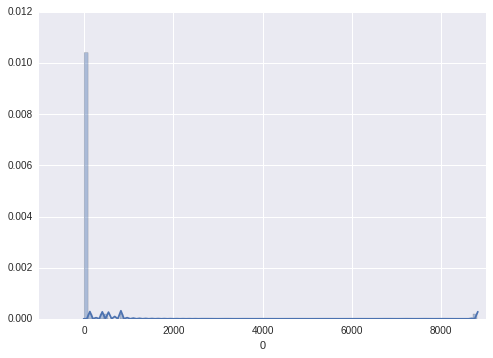

In [30]:
#train.groupby('Breed').size().reset_index()[0]
sns.distplot(train[train['AnimalType'] == 'Cat'].groupby('Breed').size().reset_index()[0], bins = 100)

### `Color`

I'm guessing that color's affect on the outcome is sometimes dependent on the animal type, and sometimes not, as in some colors may be appreciated across enmails, while some may be animal specific. Given the likely interactions between variables I would consider a model that considers interactions (neural networks, decisions trees) vs. a model that doesn't take these interactions into account automatically (logistic regression, KNN).

In [23]:
print 'Number of colors:', len(train['Color'].unique())

Number of colors: 366
